# Santander Customer Transaction Prediction
### Author: Saad Bin Manjur Adit

# Summary
In this Kaggle competition the Santander Bank wants to predict "*which customers will make a specific transaction in the future, irrespective of the amount of money transacted.*" [ [Link to the competition](https://www.kaggle.com/c/santander-customer-transaction-prediction) ]

It seems the data has been duplicated with "fake" observations and in order to get a score over 0.90 a "magic" feature needs to be created (e.g. see [this notebook](https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920)). My focus in this notebook is not to find this "magic" feature, but to go through the data science process. Nonetheless, I did some experiments and it was an interesting learning experience, and perhaps something to explore further in the future. 

Let's start.


# Load libraries and dataset

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score


## Dataset

In [2]:
### Importing dataset from Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "../input/santander-customer-transaction-prediction-dataset"

# Changing the working directory
### REMEMBER TO MOUNT GOOGLE DRIVE IF USING COLAB
#%cd /content/drive/My Drive/Kaggle

# Run this once only to download the data directly from Kaggle
#!kaggle competitions download -c santander-customer-transaction-predic

In [3]:
# Read original data
raw = pd.read_csv("../input/santander-customer-transaction-prediction-dataset/train.csv")

In [4]:
# Create a copy for manipulation
df = raw.copy()
df.drop("ID_code", axis=1, inplace=True) # Irrelevant column

# Exploratory Data Analysis

## Basic dataset insights

In [5]:
df.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0 -4.9200  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  3.1468  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2 -4.9193  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   
3 -5.8609  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275   
4  6.2654  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  
3  10.2922  17.9697  -8.9996  
4   9.5031  17.9974  -8.8104  

[5 rows x 201 columns]

In [6]:
print("The shape of the dataframe is: {:,} columns and {:,} rows".format(df.shape[1], df.shape[0]))

The shape of the dataframe is: 201 columns and 200,000 rows


In [7]:
df.dtypes.value_counts()

float64    200
int64        1
dtype: int64

In [8]:
# Is the target the only int64?
df["target"].dtype

dtype('int64')

In [9]:
# Checking NULL
null_count = sum(df.isnull().any())

print("There are {} NULL values in the dataframe".format(null_count))

There are 0 NULL values in the dataframe


In [10]:
# Seems there aren't NULL values so that's good, no need to deal with it

In [11]:
# Check basic statistics, although difficult to go into detail with so many columns
df.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [12]:
# What's the range of all variables?
df_min = min(df.drop("target", axis=1).min()) # It first calculates the min by column, and then the min of all min. Same with max.
df_max = max(df.drop("target", axis=1).max())

print("The min value in the dataframe is: {}".format(df_min))
print("The max value in the dataframe is: {}".format(df_max))

The min value in the dataframe is: -90.2525
The max value in the dataframe is: 74.0321


In [13]:
# Focusing on the target variable
obs_total = df.shape[0]
obs_0 = df["target"].value_counts()[0]
obs_1 = df["target"].value_counts()[1]

pct_0 = round(obs_0/obs_total,4)*100
pct_1 = round(obs_1/obs_total, 4)*100

print("There are {:,} observations with target value 0, and {:,} with target value 1".format(obs_0, obs_1))
print("Target 0 represents {}% of the total, while target 1 represents {}%".format(pct_0, pct_1))


There are 179,902 observations with target value 0, and 20,098 with target value 1
Target 0 represents 89.95% of the total, while target 1 represents 10.05%


In [14]:
# Clearly an imbalanced dataset, an over/under-sampling strategy will be needed.

## Graphics

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


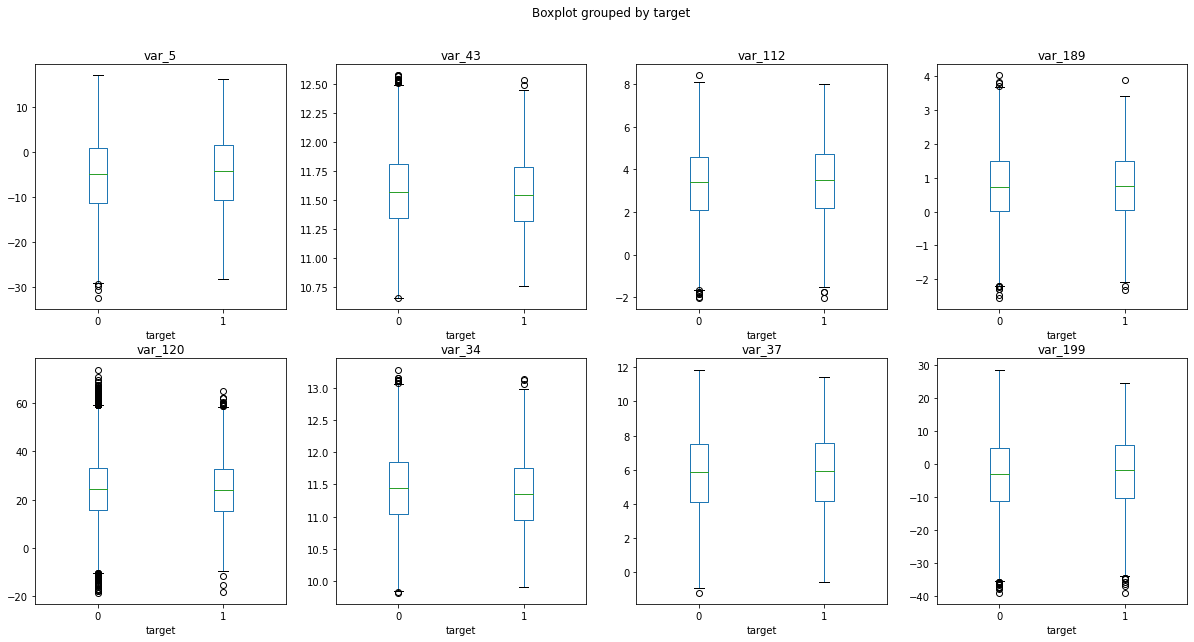

In [15]:
# Some random boxplot against the target

fig, ax = plt.subplots(2,4,figsize=(20,10), sharey=False);
df.boxplot(["var_5", "var_43", "var_112", "var_189", "var_120", "var_34", "var_37", "var_199"], by="target", grid=False, ax=ax);

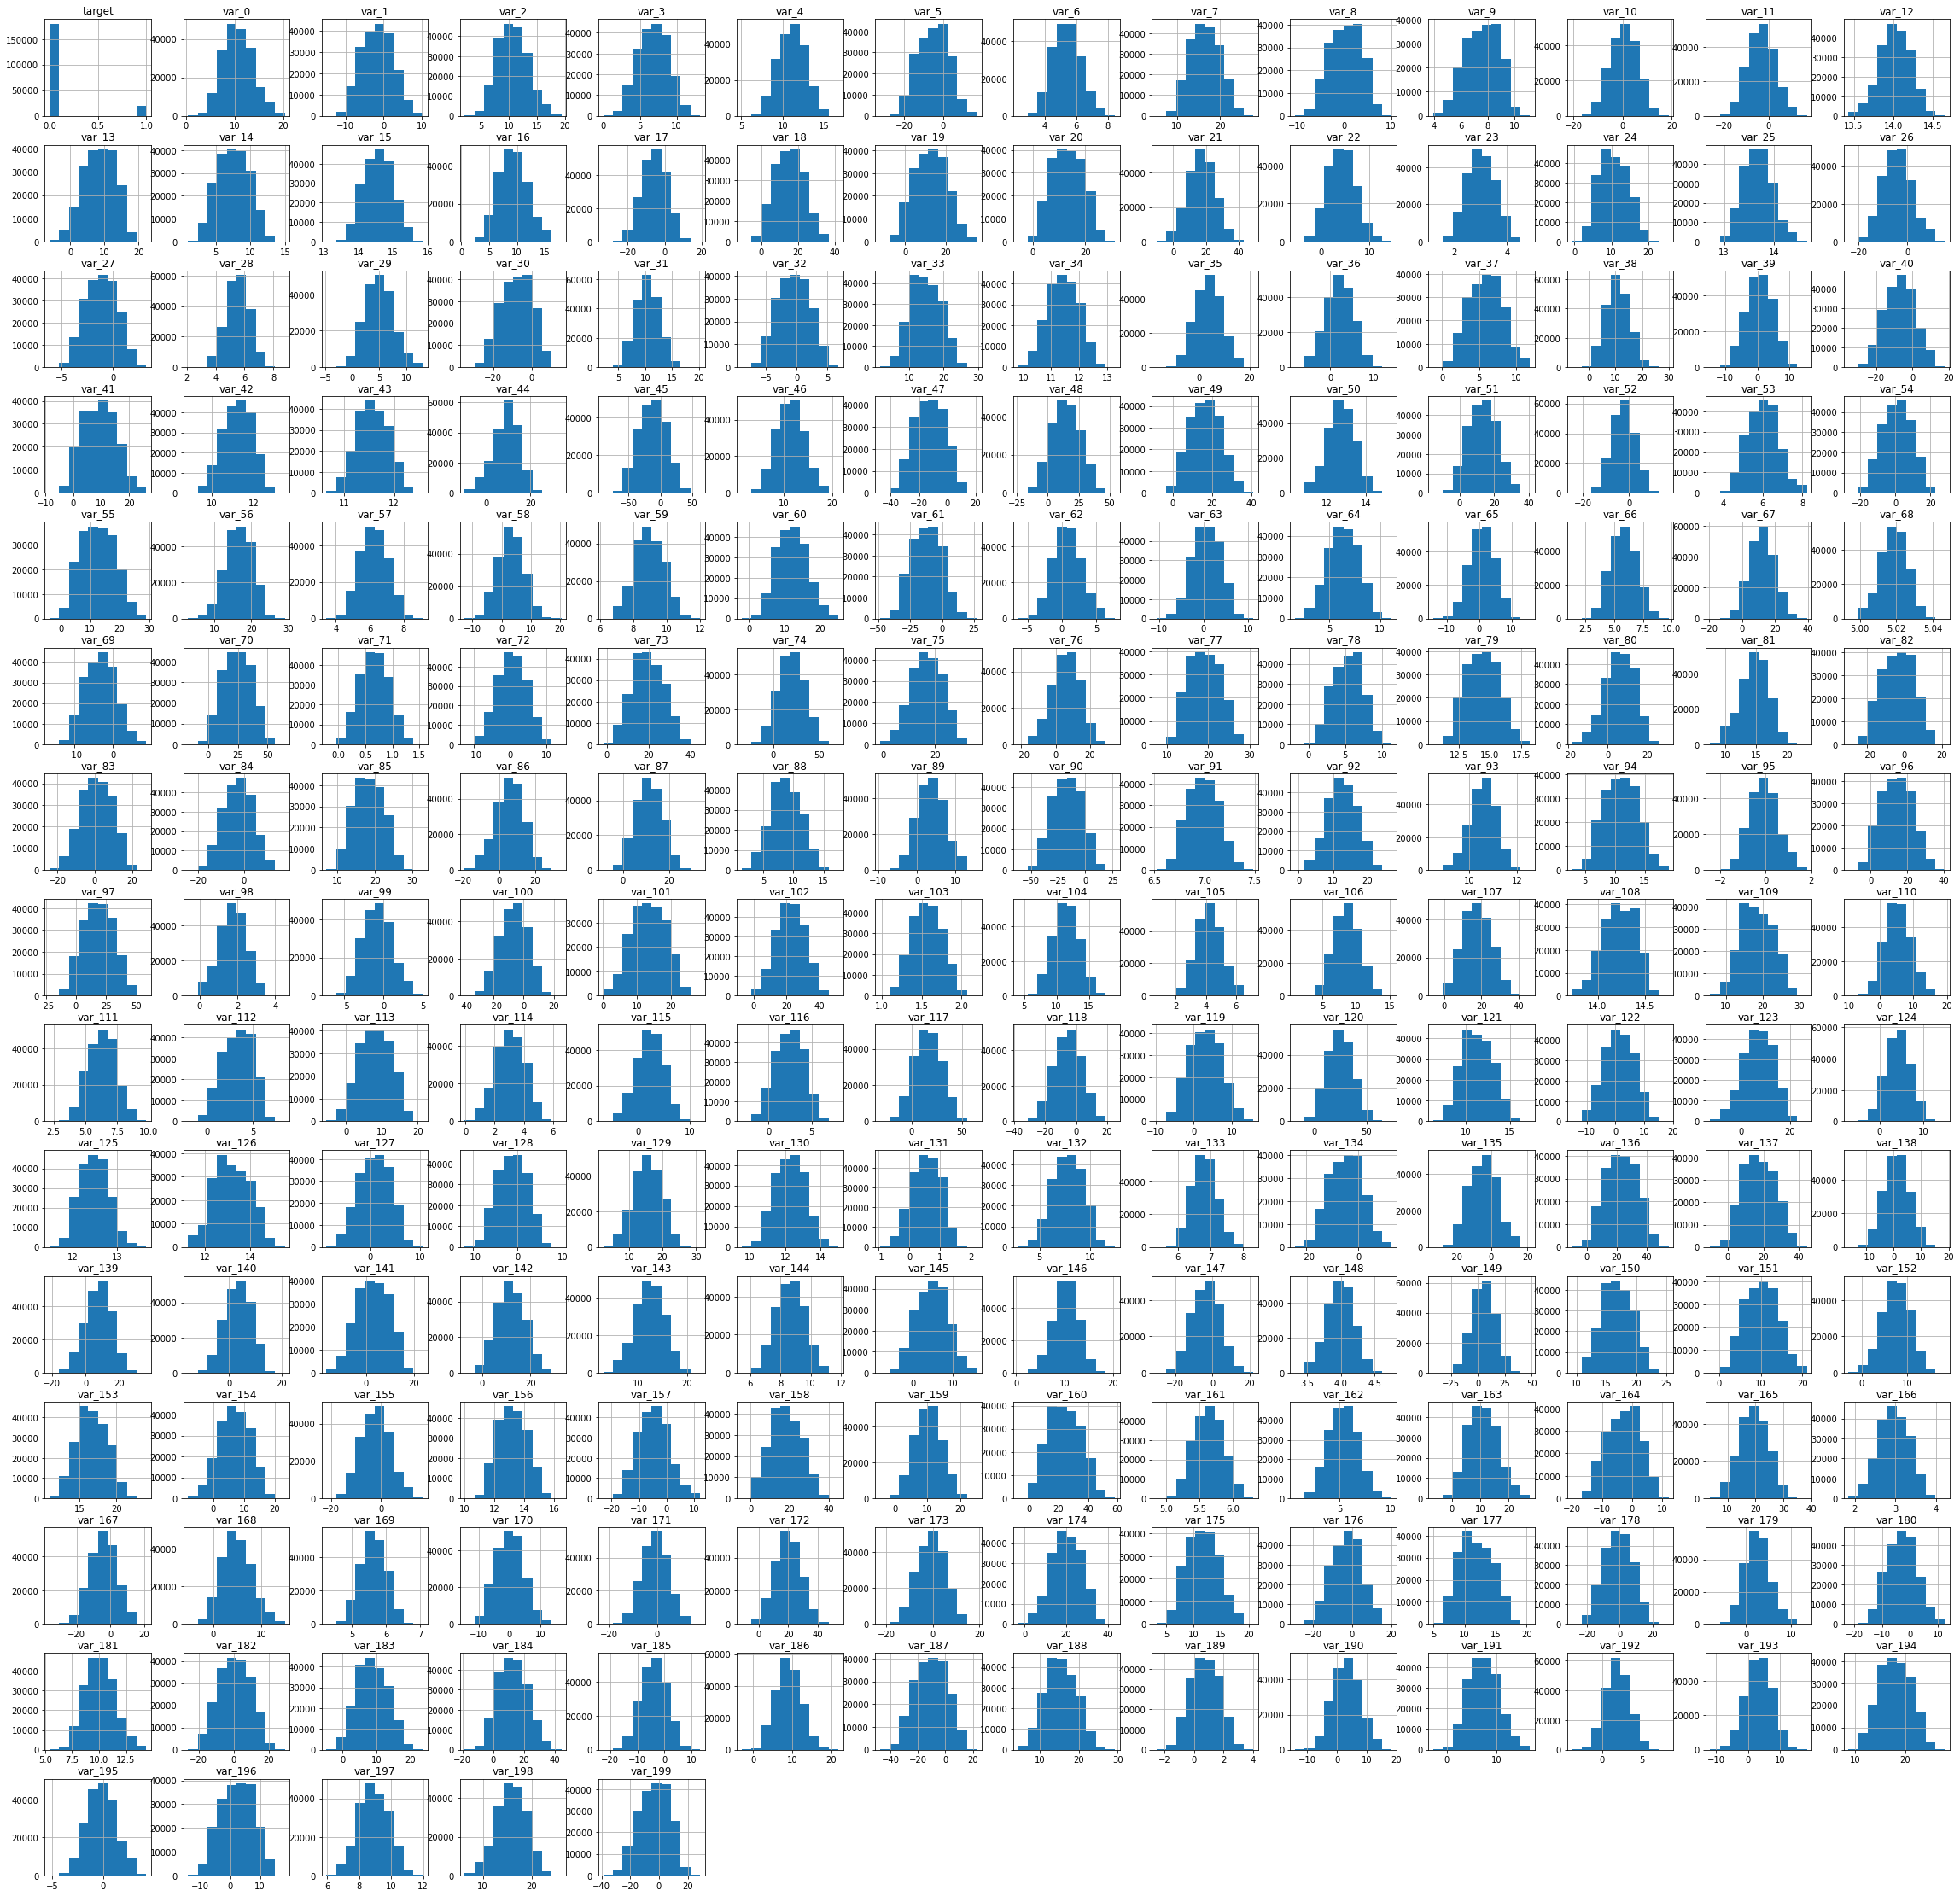

In [16]:
# How's the data distributed?
df.hist(figsize=(40,40));

## Correlations

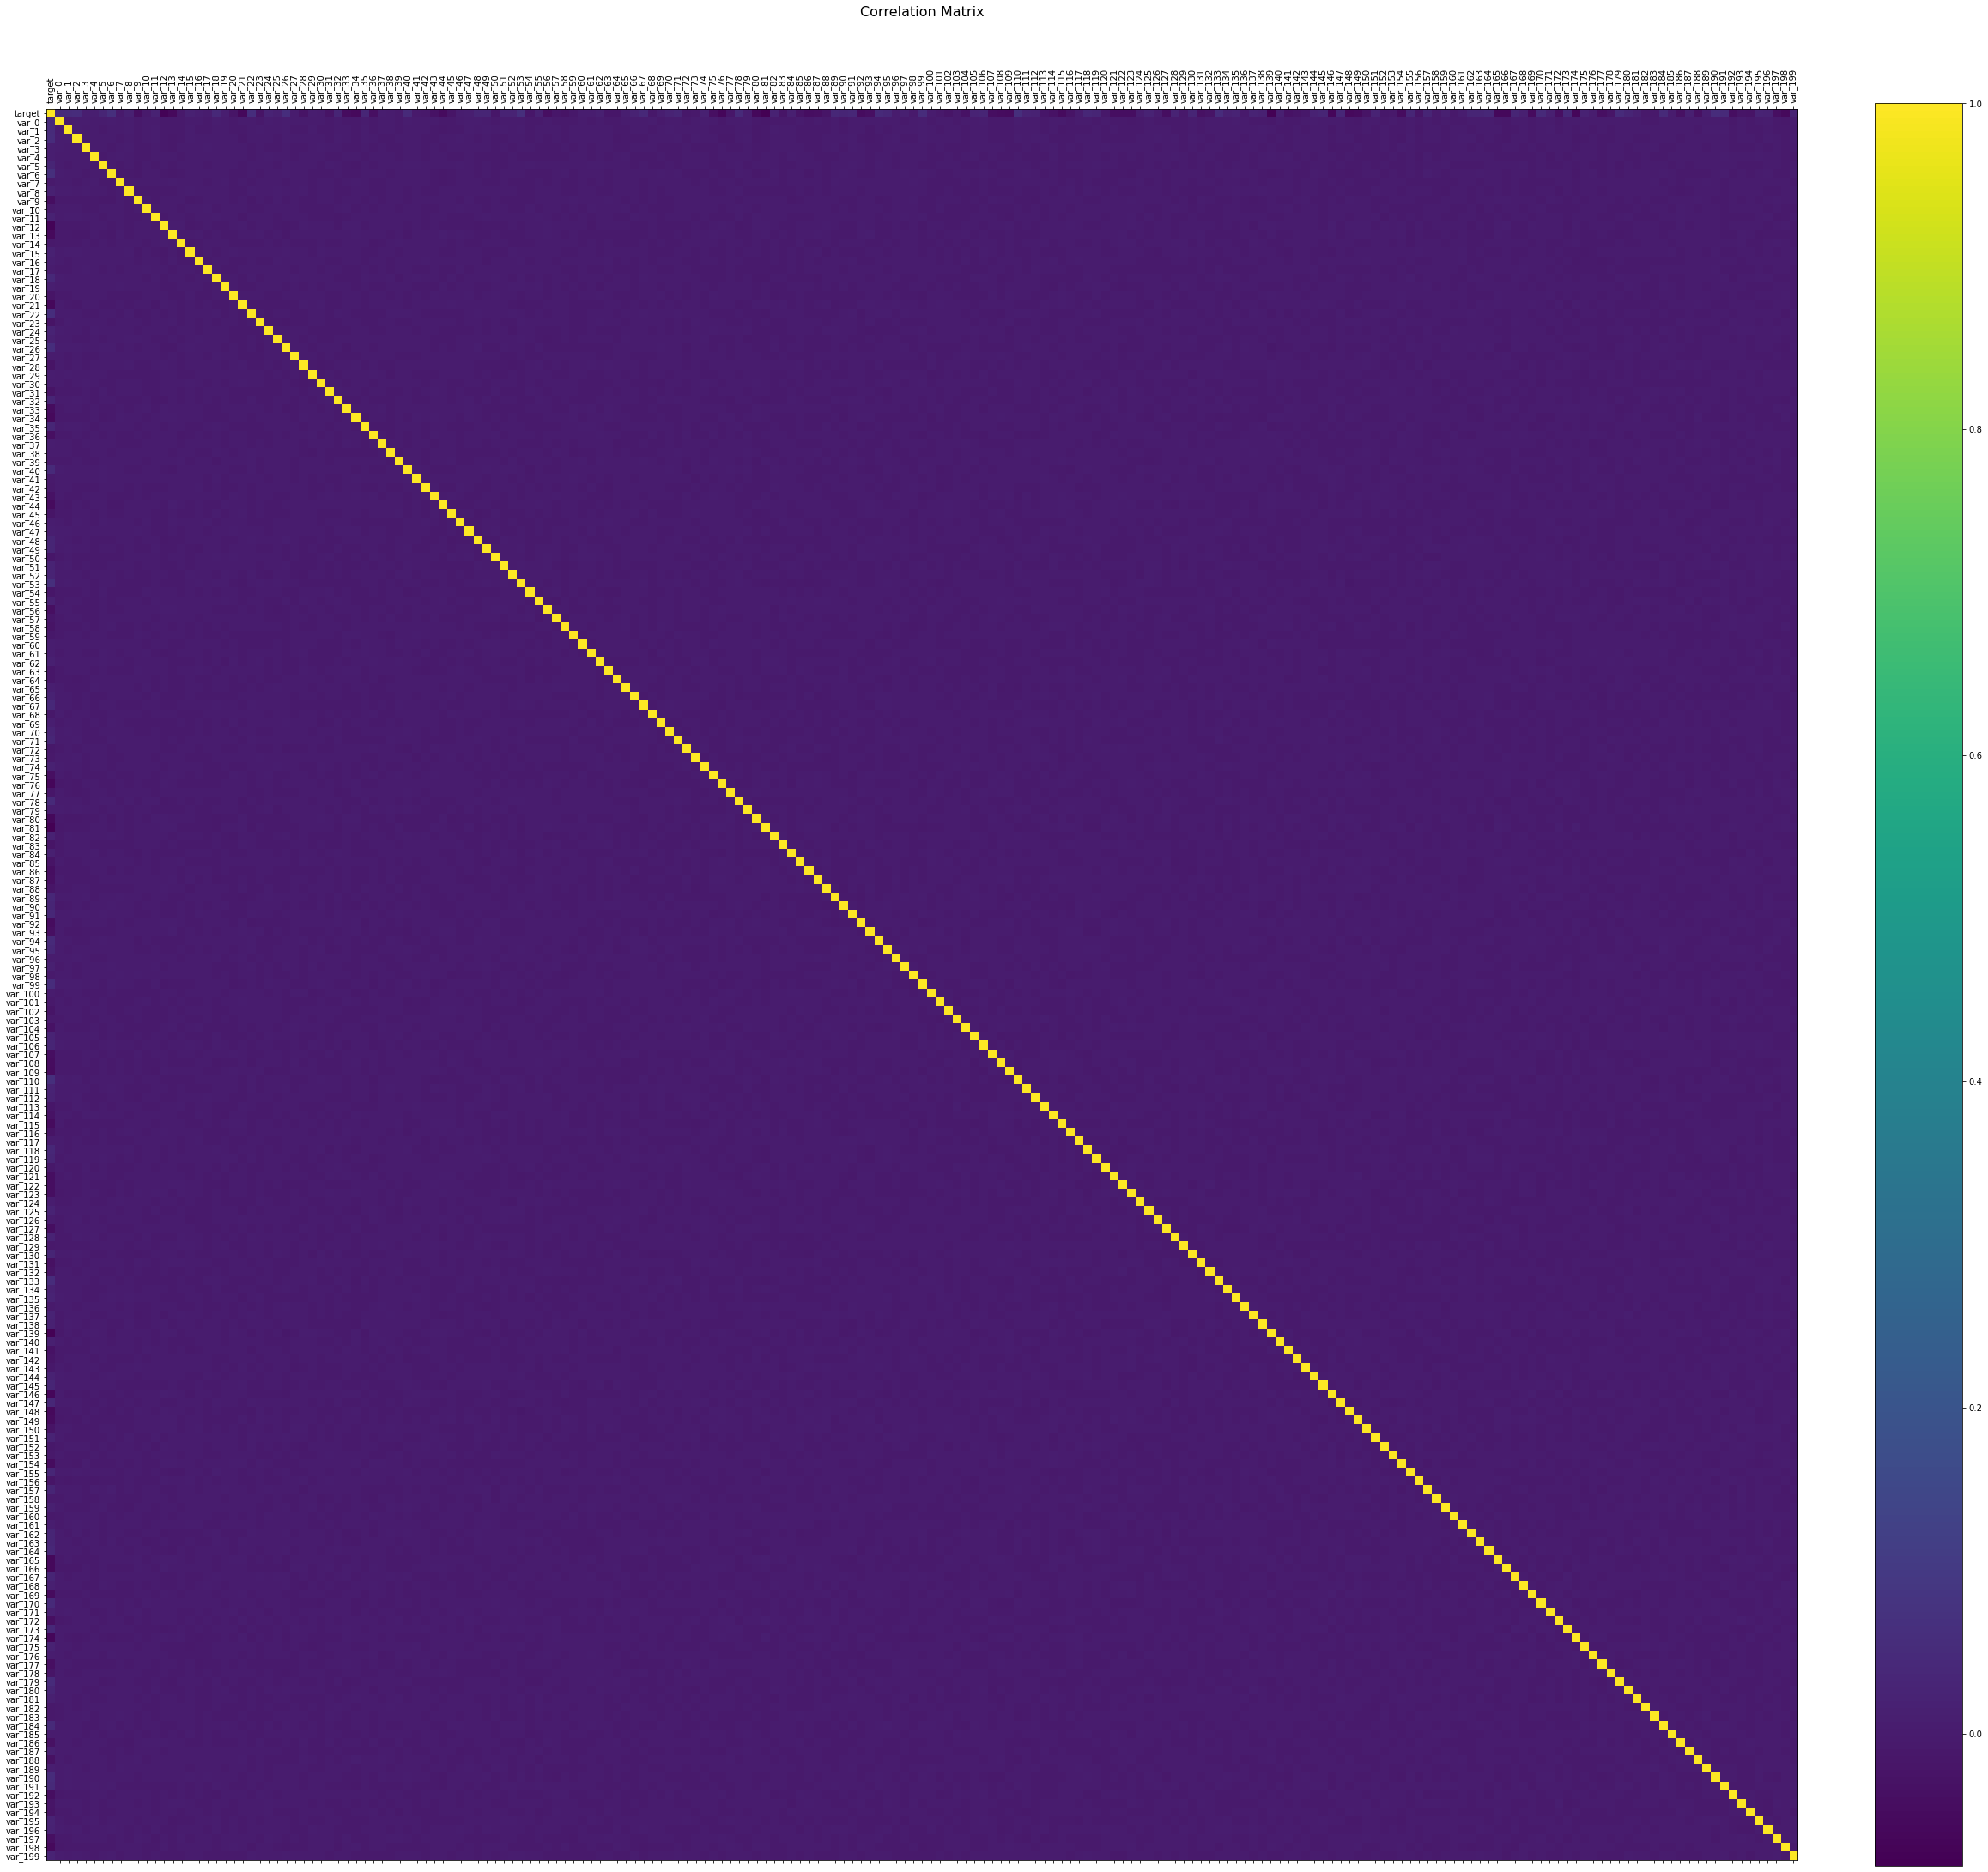

In [17]:
# Source: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
f = plt.figure(figsize=(40, 40))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar(fraction=0.046, pad = 0.04)
plt.title('Correlation Matrix', fontsize=16);

### Target

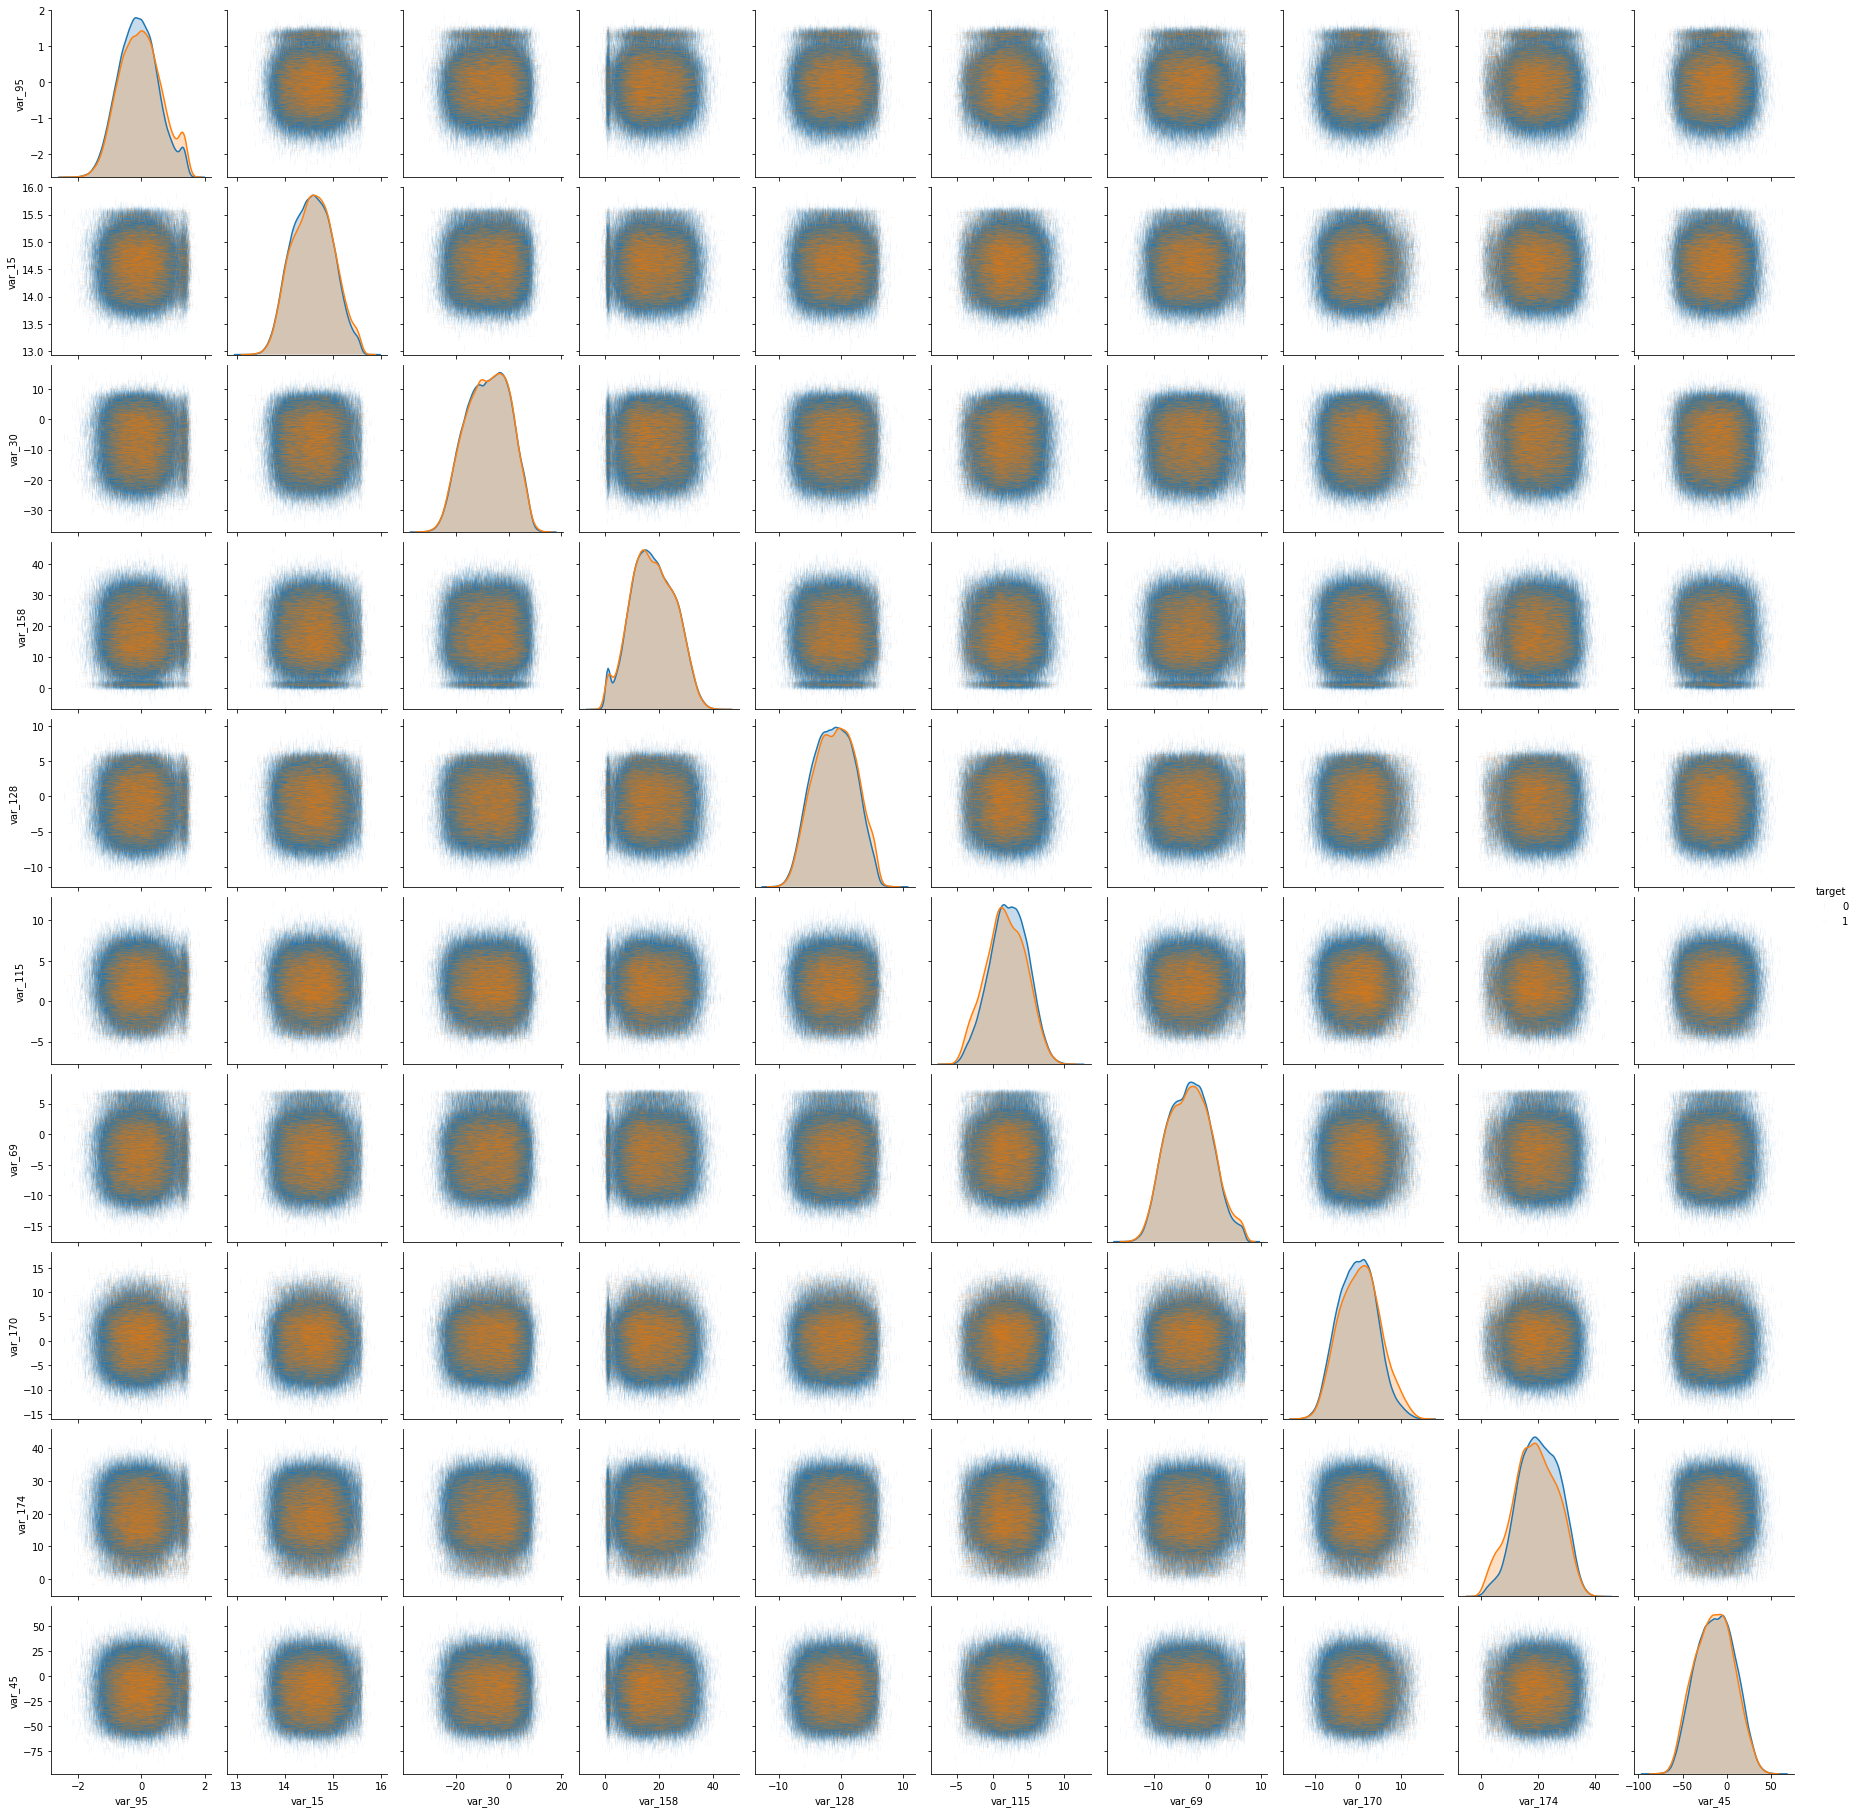

In [18]:
# Plotting the correlation of 10 random features

random_columns = df.drop("target", axis=1).sample(10, axis=1, random_state=42).columns.to_list()
sns.pairplot(df, vars=random_columns, hue="target", plot_kws={'alpha':0.05}, markers=['|','_']); # 0 is blue and 1 is orange

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


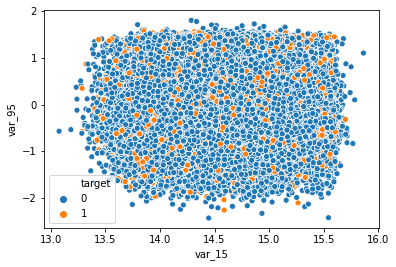

In [19]:
# Looking at the previous plot it seems that when the target is 1 it's concentrated in the middle of the data, however having a closer look shows a more random picture
sns.scatterplot("var_15", "var_95", hue="target", data = df);

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


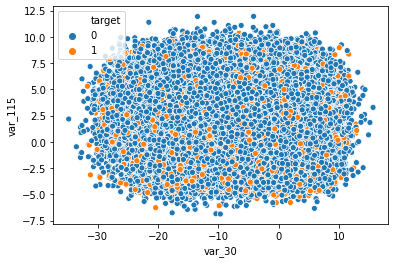

In [20]:
sns.scatterplot("var_30", "var_115", hue="target", data = df);

# Data Preparation

## Outliers

In [21]:
def identify_outliers(df):

  idx = []

  for col in df.columns:
    if not col == "target":
      std = df[col].std() 
      threshold = std * 3 
      idx_col = df[col][(df[col]>=abs(threshold)) | (df[col]<=-abs(threshold))].index.to_list()
      idx.append(idx_col)
  
  idx_flat = list(set([i for j in idx for i in j]))

  return idx_flat

In [22]:
outliers_idx = identify_outliers(df)
len(outliers_idx)

200000

In [23]:
# Can't use this method for now, since it's removing all dataset
#df1 = df.drop(df.index[outliers_idx])

In [24]:
#df.shape[0] - df1.shape[0] == len(outliers_idx) # Just a quick check

## Standardise

In [25]:
# Standardise the data for modelling
sc = StandardScaler()
df_sc = pd.DataFrame(sc.fit_transform(df.drop("target", axis=1)))
df_sc.columns = df.drop("target", axis=1).columns
df_sc["target"] = df["target"].copy()

## Downsampling
Since there are over 20K observations with the minority class I'll use the downsampling strategy.

In [26]:
df_0_downsampled = df_sc[df_sc["target"]==0].sample(len(df_sc[df_sc["target"]==1]), random_state=42)
df_1 = df_sc[df_sc["target"]==1]

df_downsampled = pd.concat([df_1, df_0_downsampled], ignore_index=True)

In [27]:
X = df_downsampled.drop("target", axis=1)
y = df_downsampled["target"]

# Modelling

## Cross-Validation
Selecting the best model between LR, RFC, GNB

In [28]:
np.random.seed(42)

models = {"Logistic Regression":LogisticRegression(),
          "Random Tree Classifier":RandomForestClassifier(),
          "Gaussian Naive Bayes":GaussianNB()
         }
results = dict()

for model in models:
  print("Fitting {}...".format(model), end = " ")
  scores = cross_val_score(models[model], X, y, cv=10, scoring = "roc_auc", n_jobs = -1)
  results[model] = scores
  score = scores.mean()
  print("Done! Mean AUC score: {}".format(score))


Fitting Logistic Regression... Done! Mean AUC score: 0.8591671323996348
Fitting Random Tree Classifier... 

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done! Mean AUC score: 0.8214542092082373
Fitting Gaussian Naive Bayes... Done! Mean AUC score: 0.8874792733212906


## Training
(Best model only)

Gaussian Naive Bayes was the best model in Cross-Validation. This model can't be fine tunned, but let's see how it performs anyway against test-train data, and finally submitting the kaggle test data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

## Testing

Test AUC: 0.8081077893276668
Test Recall: 0.8113254823352544
Test Precission: 0.8038728897715988
Test Accuracy: 0.8080845771144278




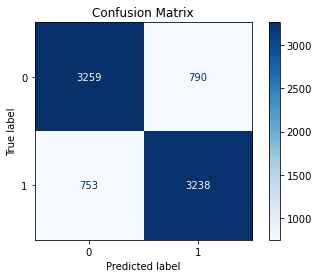

In [30]:
pred_test = gnb.predict(X_test)
print("Test AUC: {}".format(roc_auc_score(y_test, pred_test)))
print("Test Recall: {}".format(recall_score(y_test, pred_test)))
print("Test Precission: {}".format(precision_score(y_test, pred_test)))
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_test)))
print("\n")
plot_confusion_matrix(gnb, X_test, y_test, values_format=".5g", cmap="Blues")
plt.title("Confusion Matrix");

# Kaggle Submission

In [31]:
# Kaggle test, not model test
#df_test = pd.read_csv("test.csv.zip", compression='zip')

In [32]:
# Re-train with all data

#gnb_kaggle = GaussianNB()
#gnb_kaggle.fit(X, y)

#kaggle_X_test = sc.transform(df_test.drop("ID_code", axis=1))

#kaggle_pred = gnb_kaggle.predict(kaggle_X_test)

#submission = pd.DataFrame()
#submission["ID_code"] = df_test["ID_code"].copy()
#submission["target"] = kaggle_pred

#submission.to_csv("kaggle_santander_transactions_submission.csv", index=False)

# THIS RETURNS A 0.80469 PRIVATE SCORE ON KAGGLE (highest I ever had)

In [33]:
#!kaggle competitions submit -c santander-customer-transaction-prediction -f kaggle_santander_transactions_submission.csv -m "Submission"

# Results

Gaussian Naive Bayes was the best performing model of the 3 (Logistic Regression, Random Forest Classifier and Gaussian Naive Bayes), but also the fastest. RFC was the slowest one.

The main metric used during the modelling was the ROC-AUC. GNB also returned good results in other metrics such as Recall and Precission, where these are very important in an imbalanced dataset (which one is more importan will depend on specific cases, uses and policies).

After re-training the model with all the data and submitting the test data to Kaggle it returned a 80.47% score, which is the highest I ever achieved for this competition.

As next steps, a deeper look into the outliers would be a good idea. I tried to use a 3 times the Standard Deviation approach to identify outliers but it was deleting the whole dataset... Also, I didn't perform any data reduction since the models could handle all the dataset. However, experimenting with this would also be a good next step.

## Thank you